In [1]:
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import statsmodels.formula.api as smf
from patsy.contrasts import Sum
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import sem
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()
# import the BayesFactor R package
BayesFactor = importr('BayesFactor')
import warnings
warnings.filterwarnings('ignore')

# Load Data


In [2]:
path_to_prek = '/Users/caffarra/Documents/Projects/PREK/analyses/PREK_tracts.csv'
prek_file = pd.read_csv(path_to_prek)
# rescale the MD values
prek_file['dti_md_rescale'] = prek_file.dti_md*1000
prek_file

,Unnamed_0,tractID,nodeID,dti_fa,dti_md,subjectID,sessionID,Group,dti_md_rescale
0,0,ATR_R,0,0.274050,0.000727,1103,post,1,0.727200
1,1,ATR_R,1,0.292497,0.000739,1103,post,1,0.738705
2,2,ATR_R,2,0.307782,0.000744,1103,post,1,0.743912
3,3,ATR_R,3,0.321004,0.000745,1103,post,1,0.745229
4,4,ATR_R,4,0.334779,0.000743,1103,post,1,0.743166
...,...,...,...,...,...,...,...,...,...
172795,1795,FP,95,0.342362,0.000779,1966,pre,1,0.779204
172796,1796,FP,96,0.310556,0.000786,1966,pre,1,0.785591
172797,1797,FP,97,0.277714,0.000794,1966,pre,1,0.794212
172798,1798,FP,98,0.242538,0.000803,1966,pre,1,0.803362


# Clean the dataset


In [3]:
prek_file = prek_file[prek_file.subjectID!=1241] # bad anatomy
index = prek_file[(prek_file.subjectID == 1113) & (prek_file.sessionID == 'post')].index # movement
prek_file.drop(index, inplace = True)
index = prek_file[(prek_file.subjectID == 1939) & (prek_file.sessionID == 'post')].index # movement
prek_file.drop(index, inplace = True)
index = prek_file[(prek_file.subjectID == 1966) & (prek_file.sessionID == 'pre')].index # movement
prek_file.drop(index, inplace = True)
index = prek_file[(prek_file.subjectID == 1812) & (prek_file.sessionID == 'post')].index # movement
prek_file.drop(index, inplace = True)
index = prek_file[(prek_file.subjectID == 1443) & (prek_file.sessionID == 'pre')].index # movement
prek_file.drop(index, inplace = True)
index = prek_file[(prek_file.subjectID == 1184) & (prek_file.sessionID == 'post')].index # movement
prek_file.drop(index, inplace = True)
index = prek_file[(prek_file.subjectID == 1715) & (prek_file.sessionID == 'pre')].index # movement
prek_file.drop(index, inplace = True)
index = prek_file[(prek_file.subjectID == 1382) & (prek_file.sessionID == 'pre')].index # movement
prek_file.drop(index, inplace = True)
index = prek_file[(prek_file.subjectID == 1691) & (prek_file.sessionID == 'post')].index # movement
prek_file.drop(index, inplace = True)
index = prek_file[(prek_file.subjectID == 1372) & (prek_file.sessionID == 'pre')].index # movement
prek_file.drop(index, inplace = True)
index = prek_file[(prek_file.subjectID == 1936) & (prek_file.sessionID == 'pre')].index # movement
prek_file.drop(index, inplace = True)
index = prek_file[(prek_file.subjectID == 1751) & (prek_file.sessionID == 'pre')].index # movement
prek_file.drop(index, inplace = True)
prek_file

,Unnamed_0,tractID,nodeID,dti_fa,dti_md,subjectID,sessionID,Group,dti_md_rescale
0,0,ATR_R,0,0.274050,0.000727,1103,post,1,0.727200
1,1,ATR_R,1,0.292497,0.000739,1103,post,1,0.738705
2,2,ATR_R,2,0.307782,0.000744,1103,post,1,0.743912
3,3,ATR_R,3,0.321004,0.000745,1103,post,1,0.745229
4,4,ATR_R,4,0.334779,0.000743,1103,post,1,0.743166
...,...,...,...,...,...,...,...,...,...
170995,1795,FP,95,0.346725,0.000762,1966,post,1,0.761643
170996,1796,FP,96,0.316837,0.000764,1966,post,1,0.763824
170997,1797,FP,97,0.286391,0.000769,1966,post,1,0.768901
170998,1798,FP,98,0.240696,0.000778,1966,post,1,0.778233


In [4]:
# get the overall number of subject
print('Number of participants in Letter Pre '+ str(len(np.unique(prek_file.subjectID[(prek_file.Group==0) & (prek_file.sessionID =='pre')]))))
print('Number of participants in Letter Post '+ str(len(np.unique(prek_file.subjectID[(prek_file.Group==0) & (prek_file.sessionID =='post')]))))
print('Number of participants in Language Pre '+ str(len(np.unique(prek_file.subjectID[(prek_file.Group==1) & (prek_file.sessionID =='pre')]))))
print('Number of participants in Language Post '+ str(len(np.unique(prek_file.subjectID[(prek_file.Group==1) & (prek_file.sessionID =='post')]))))

Number of participants in Letter Pre 21
Number of participants in Letter Post 22
Number of participants in Language Pre 19
Number of participants in Language Post 20


# By tract Test-Retest reliability

In [5]:
prek_file
bad_sj = [1241, 1113, 1939, 1966, 1812, 1443, 1184, 1715, 1382, 1691, 1372, 1936, 1751]
prek_file_clean = prek_file[prek_file['subjectID'].isin(bad_sj)==False]
tract_list = np.unique(prek_file_clean.tractID)
sj_list = np.unique(prek_file_clean.subjectID) # only the 35 subjects with time points
df_TRR = pd.DataFrame(columns = ['sj', 'group', 'tract', 'r_fa', 'r_md'])

for tract in tract_list:
    temp = prek_file_clean[prek_file_clean.tractID == tract]
    for sj in sj_list:
        temp_sj = temp[temp.subjectID == sj]
        temp_sj_pre = temp_sj[temp_sj.sessionID == 'pre']
        temp_sj_post = temp_sj[temp_sj.sessionID == 'post']
        group = np.unique(temp_sj.Group)
        r_fa, p_fa = stats.pearsonr(temp_sj_pre.dti_fa, temp_sj_post.dti_fa)
        r_md, p_md = stats.pearsonr(temp_sj_pre.dti_md_rescale, temp_sj_post.dti_md_rescale)
        mini_df = pd.DataFrame([[sj, group, tract, r_fa, r_md]], columns = ['sj', 'group', 'tract', 'r_fa', 'r_md'])
        df_TRR = df_TRR.append(mini_df)
  
df_TRR = df_TRR.reset_index(drop =True)
df_TRR

,sj,group,tract,r_fa,r_md
0,1103,[1],ARC_L,0.974863,0.906279
1,1110,[1],ARC_L,0.993070,0.936593
2,1112,[0],ARC_L,0.977121,0.931960
3,1208,[1],ARC_L,0.986762,0.982849
4,1210,[0],ARC_L,0.984089,0.985911
...,...,...,...,...,...
625,1916,[0],UNC_R,0.978239,0.898358
626,1921,[1],UNC_R,0.991645,0.956498
627,1940,[1],UNC_R,0.879499,0.832955
628,1951,[0],UNC_R,0.990512,0.986839


In [6]:
df_TRR_tract = df_TRR.groupby(['tract'], as_index=False).agg({'r_fa':'median', 'r_md':'median'})
print('minimum value FA: ', np.min(df_TRR_tract.r_fa))
print('maximum value FA: ', np.max(df_TRR_tract.r_fa))
print('minimum value MD: ', np.min(df_TRR_tract.r_md))
print('maximum value MD: ', np.max(df_TRR_tract.r_md))
print('median value FA: ', np.median(df_TRR_tract.r_fa))
print('median value MD: ', np.median(df_TRR_tract.r_md))

minimum value FA:  0.9281752335240193
maximum value FA:  0.9947046014561217
minimum value MD:  0.6507739309106501
maximum value MD:  0.9866159607414029
median value FA:  0.9862620150697612
median value MD:  0.9210861198696629


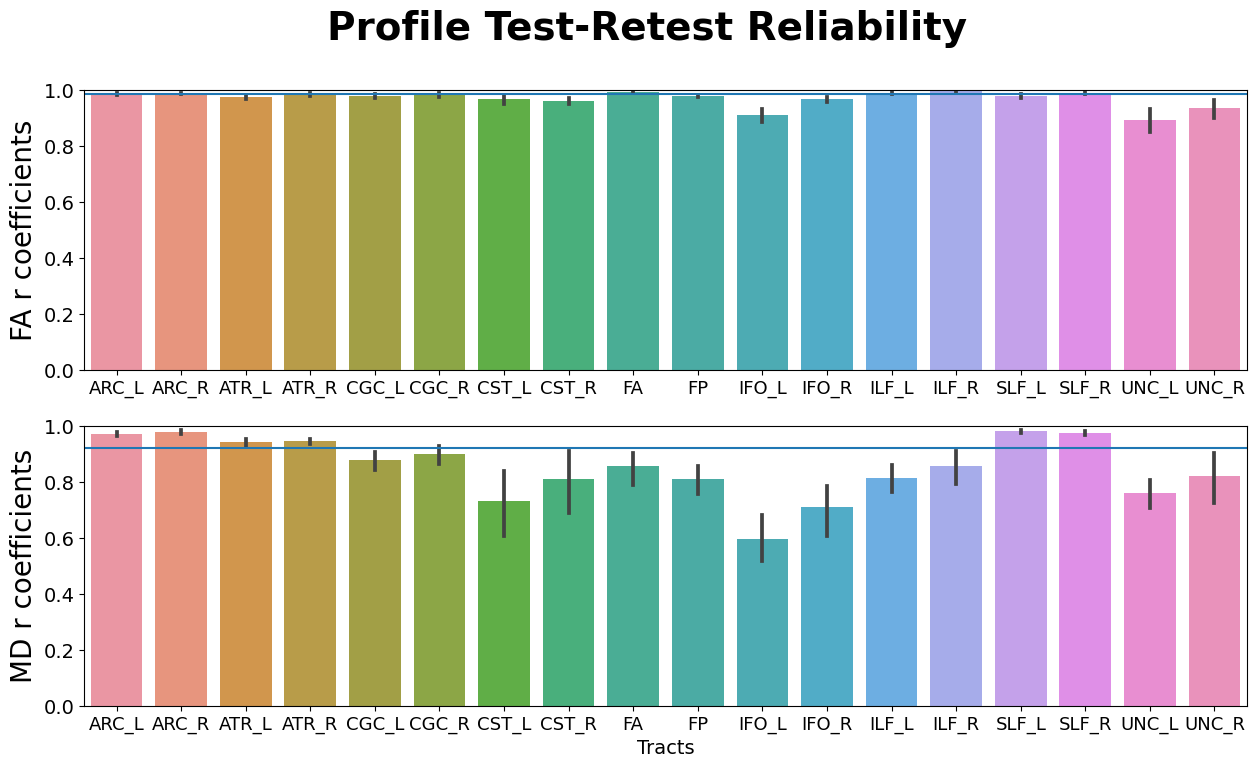

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8),sharey= True)
fig.suptitle('Profile Test-Retest Reliability', weight='bold', fontsize= 28)
g = sns.barplot(x = df_TRR.tract, y = df_TRR.r_fa, ax = axes[0])
g.axhline(np.median(df_TRR_tract['r_fa']))
g.set_ylim((0,1))
g.set_ylabel('FA r coefficients', size =20)
g.set_xlabel(None)
g.set_yticklabels(g.get_yticklabels(), size = 14)
g.set_xticklabels(g.get_xticklabels(), size = 13)
p = sns.barplot(x = df_TRR.tract, y = df_TRR.r_md, ax = axes[1])
p.axhline(np.median(df_TRR_tract['r_md']))
p.set_ylim((0,1))
p.set_ylabel('MD r coefficients', size =20)
p.set_xlabel('Tracts', size = 14)
p.set_yticklabels(g.get_yticklabels(), size = 14)
p.set_xticklabels(g.get_xticklabels(), size = 13)

fig.show()


# By subject Test-Retest Reliability

In [8]:
# Get a database dropping the nodes and with median for each tract
prek_TT_long = prek_file.groupby(['tractID','subjectID','sessionID','Group'], as_index=False).agg({'dti_md_rescale':'median', 'dti_fa':'median'})

# from long to wide format
prek_TT_wide = prek_TT_long.pivot_table(index = ['Group', 'subjectID','tractID'], columns = ['sessionID'], values = ['dti_md_rescale','dti_fa']).reset_index()

# column names in one line
prek_TT_wide.columns = [c[1] + '_' + c[0]  for c in prek_TT_wide.columns]

# creat a new column with the name of the group
prek_TT_wide.loc[prek_TT_wide._Group == 0, 'groupID']='Letter'
prek_TT_wide.loc[(prek_TT_wide._Group == 1), 'groupID']='Language'

prek_TT_wide

,_Group,_subjectID,_tractID,post_dti_fa,pre_dti_fa,post_dti_md_rescale,pre_dti_md_rescale,groupID
0,0,1112,ARC_L,0.479917,0.474250,0.752636,0.758747,Letter
1,0,1112,ARC_R,0.445418,0.440395,0.775947,0.777603,Letter
2,0,1112,ATR_L,0.364362,0.364357,0.748615,0.740661,Letter
3,0,1112,ATR_R,0.365649,0.361416,0.737734,0.724498,Letter
4,0,1112,CGC_L,0.506747,0.481895,0.751287,0.750107,Letter
...,...,...,...,...,...,...,...,...
841,1,1966,ILF_R,0.479371,NaN,0.795712,NaN,Language
842,1,1966,SLF_L,0.426074,NaN,0.721523,NaN,Language
843,1,1966,SLF_R,0.419337,NaN,0.725627,NaN,Language
844,1,1966,UNC_L,0.442322,NaN,0.784561,NaN,Language


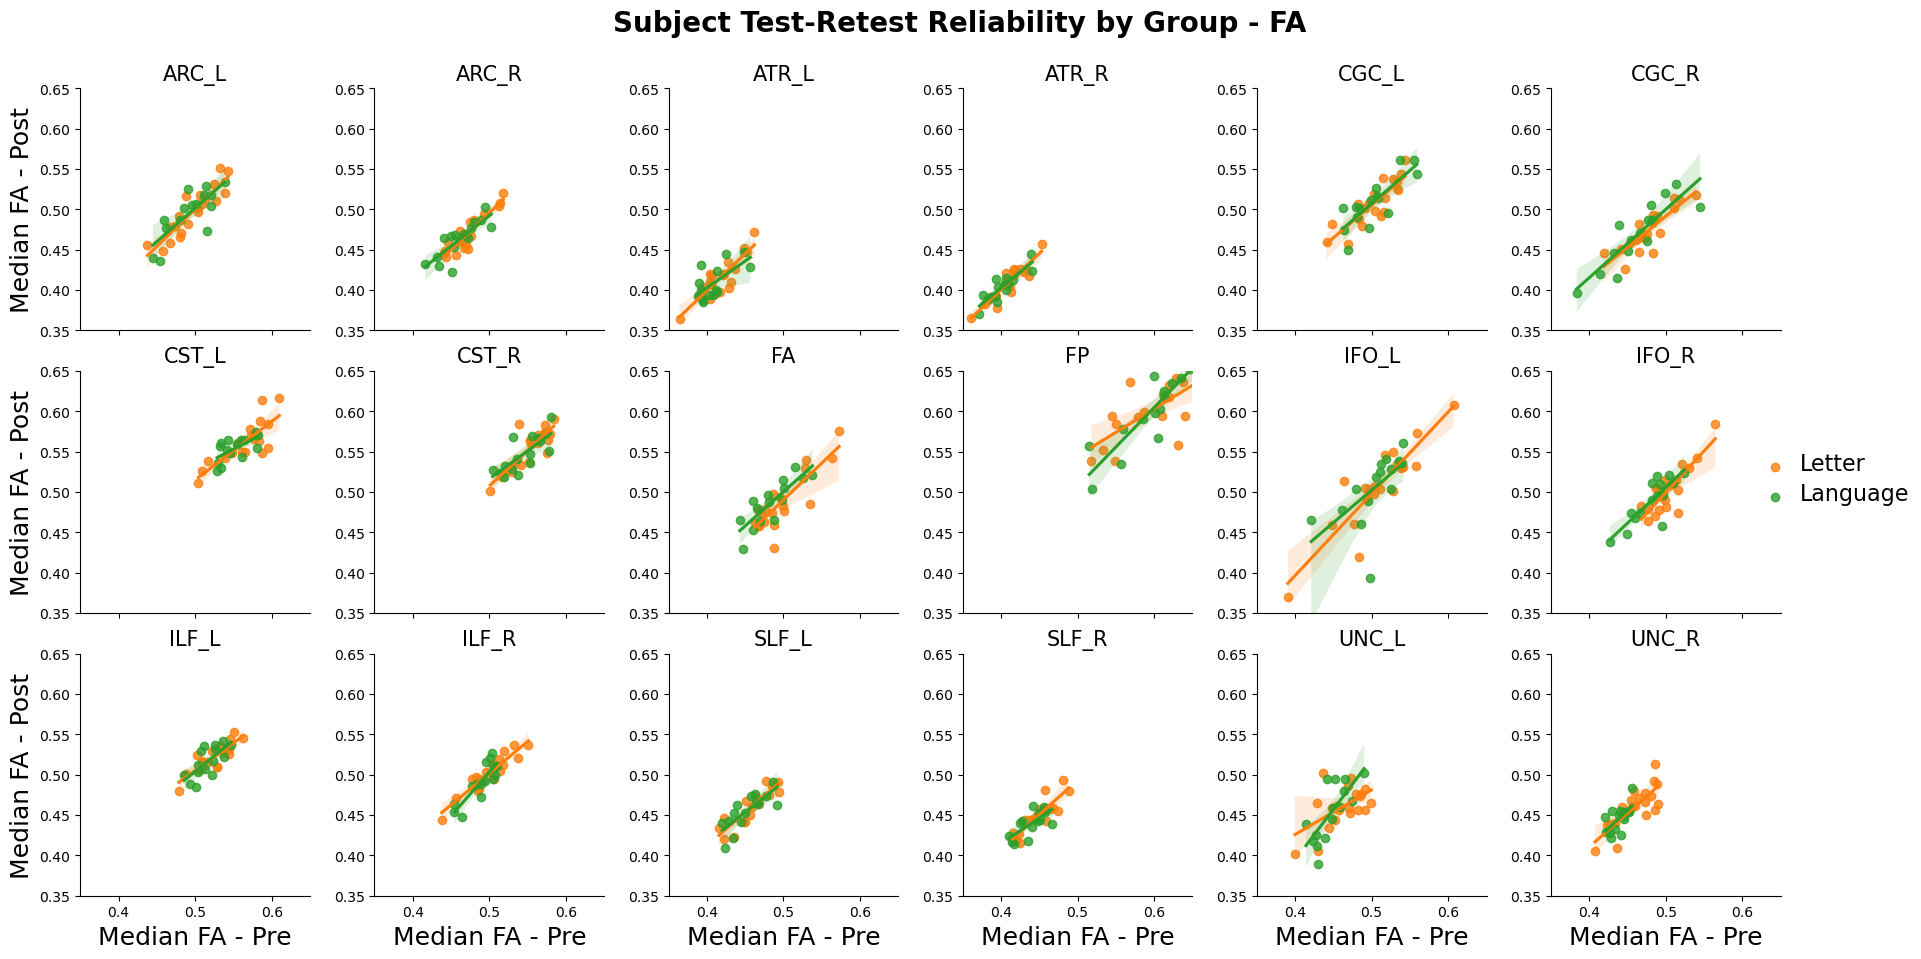

In [9]:

# Main plot with tract profiles
g = sns.FacetGrid(prek_TT_wide, col="_tractID", 
                  col_wrap=6, hue='groupID', palette = ['tab:orange','tab:green'], sharey= False)
g.map(sns.regplot, "pre_dti_fa",'post_dti_fa')
g.set(ylim=(0.35,0.65))
g.set(xlim=(0.35,0.65))
g.set_ylabels('Median FA - Post', size = 18)
g.set_xlabels('Median FA - Pre', size = 18)
g.fig.suptitle('Subject Test-Retest Reliability by Group - FA',fontsize=20, fontweight="bold", y = 1.05)

# Legend
g.add_legend()
# Legend title
g.legend.set_title(None)
# Legend texts
for text in g.legend.texts:
    text.set_fontsize(16)
    
for col_val, ax in g.axes_dict.items():
    ax.set_title(col_val, size = 15)


In [40]:
g.savefig('TRR_byGroup_FA.tiff', format='tiff', dpi=600)

### MD Subject TRR by Group

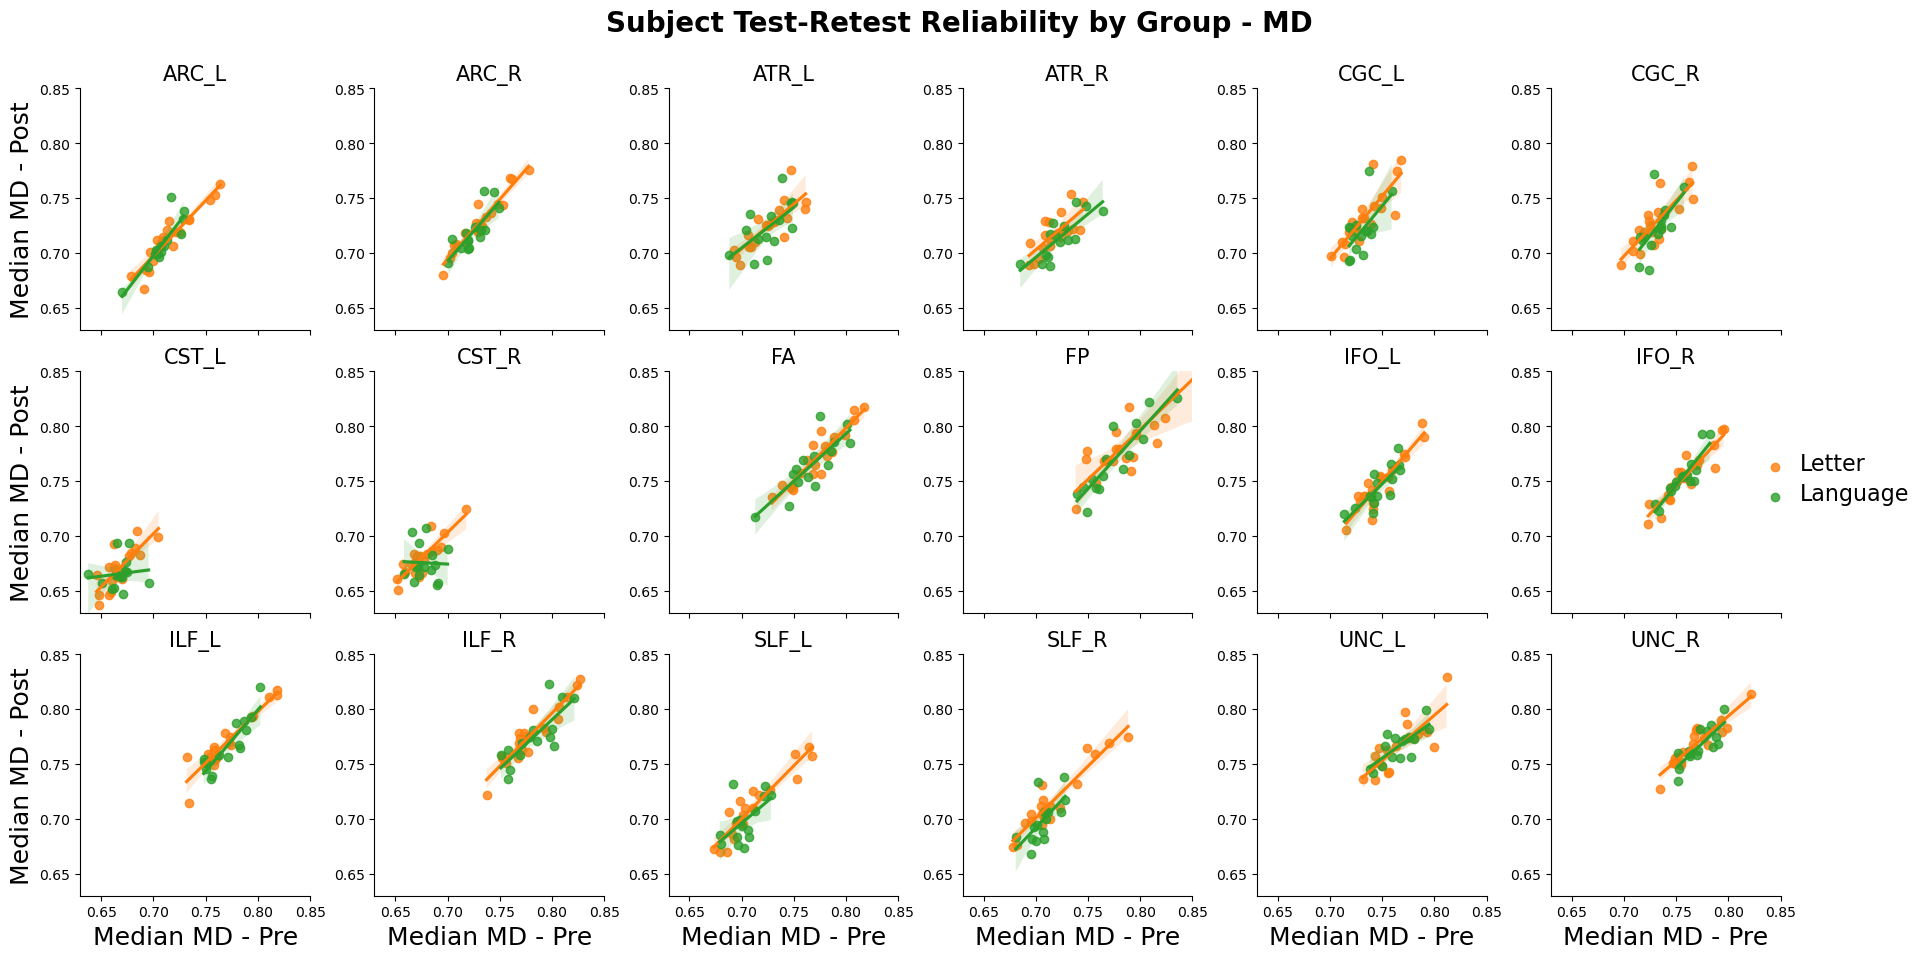

In [10]:
# Main plot with tract profiles - MD
g = sns.FacetGrid(prek_TT_wide, col="_tractID", 
                  col_wrap=6, hue='groupID', palette = ['tab:orange','tab:green'], sharey= False)
g.map(sns.regplot, "pre_dti_md_rescale",'post_dti_md_rescale')
g.set(ylim=(0.63,0.85))
g.set(xlim=(0.63,0.85))
g.set_ylabels('Median MD - Post', size = 18)
g.set_xlabels('Median MD - Pre', size = 18)
g.fig.suptitle('Subject Test-Retest Reliability by Group - MD',fontsize=20, fontweight="bold", y = 1.05)

# Legend
g.add_legend()
# Legend title
g.legend.set_title(None)
# Legend texts
for text in g.legend.texts:
    text.set_fontsize(16)
    
for col_val, ax in g.axes_dict.items():
    ax.set_title(col_val, size = 15)


In [42]:
g.savefig('TRR_byGroup_MD.tiff', format='tiff', dpi=600)

In [11]:
# Get a dataframe to plot an histogram of the r values

tract_list = np.unique(prek_TT_wide['_tractID'])
prek_TT_hist = pd.DataFrame(columns = ['tractID','r_fa','r_md'])

for tract,n_tract in zip(tract_list, range(0,len(tract_list))):
    # get values for one tract
    prek_tract = prek_TT_wide[prek_TT_wide['_tractID'] == tract]   
    # calculate md correlations after dropping nas
    md_pre = prek_tract['pre_dti_md_rescale']
    md_post = prek_tract['post_dti_md_rescale']
    nas_md = np.logical_or(md_pre.apply(np.isnan),md_post.apply(np.isnan))
    r_md, p_md = stats.pearsonr(md_pre[~nas_md], md_post[~nas_md])
    # calculate fa correlations after dropping nas
    fa_pre = prek_tract['pre_dti_fa']
    fa_post = prek_tract['post_dti_fa']
    nas_fa = np.logical_or(fa_pre.apply(np.isnan),fa_post.apply(np.isnan))
    r_fa, p_fa = stats.pearsonr(fa_pre[~nas_fa], fa_post[~nas_fa])
    # fill the dataframe with the r and p values of this tract
    mini_df = pd.DataFrame([[tract, r_fa, r_md]],columns = ['tractID','r_fa','r_md'])
    prek_TT_hist = prek_TT_hist.append(mini_df) 

prek_TT_hist.index = prek_TT_hist['tractID']
prek_TT_hist

,tractID,r_fa,r_md
tractID,,,
ARC_L,ARC_L,0.850384,0.914575
ARC_R,ARC_R,0.872237,0.918631
ATR_L,ATR_L,0.798015,0.732690
ATR_R,ATR_R,0.899772,0.734315
CGC_L,CGC_L,0.837540,0.756651
CGC_R,CGC_R,0.857519,0.741207
CST_L,CST_L,0.787240,0.563623
CST_R,CST_R,0.803400,0.547408
FA,FA,0.827804,0.879490


In [12]:
print('minimum value FA: ', np.min(prek_TT_hist.r_fa))
print('maximum value FA: ', np.max(prek_TT_hist.r_fa))
print('minimum value MD: ', np.min(prek_TT_hist.r_md))
print('maximum value MD: ', np.max(prek_TT_hist.r_md))
print('median value FA: ', np.median(prek_TT_hist.r_fa))
print('median value MD: ', np.median(prek_TT_hist.r_md))

minimum value FA:  0.620480703918741
maximum value FA:  0.8997715688409944
minimum value MD:  0.5474075299127216
maximum value MD:  0.9186310607913194
median value FA:  0.827668614866041
median value MD:  0.8661756915603636


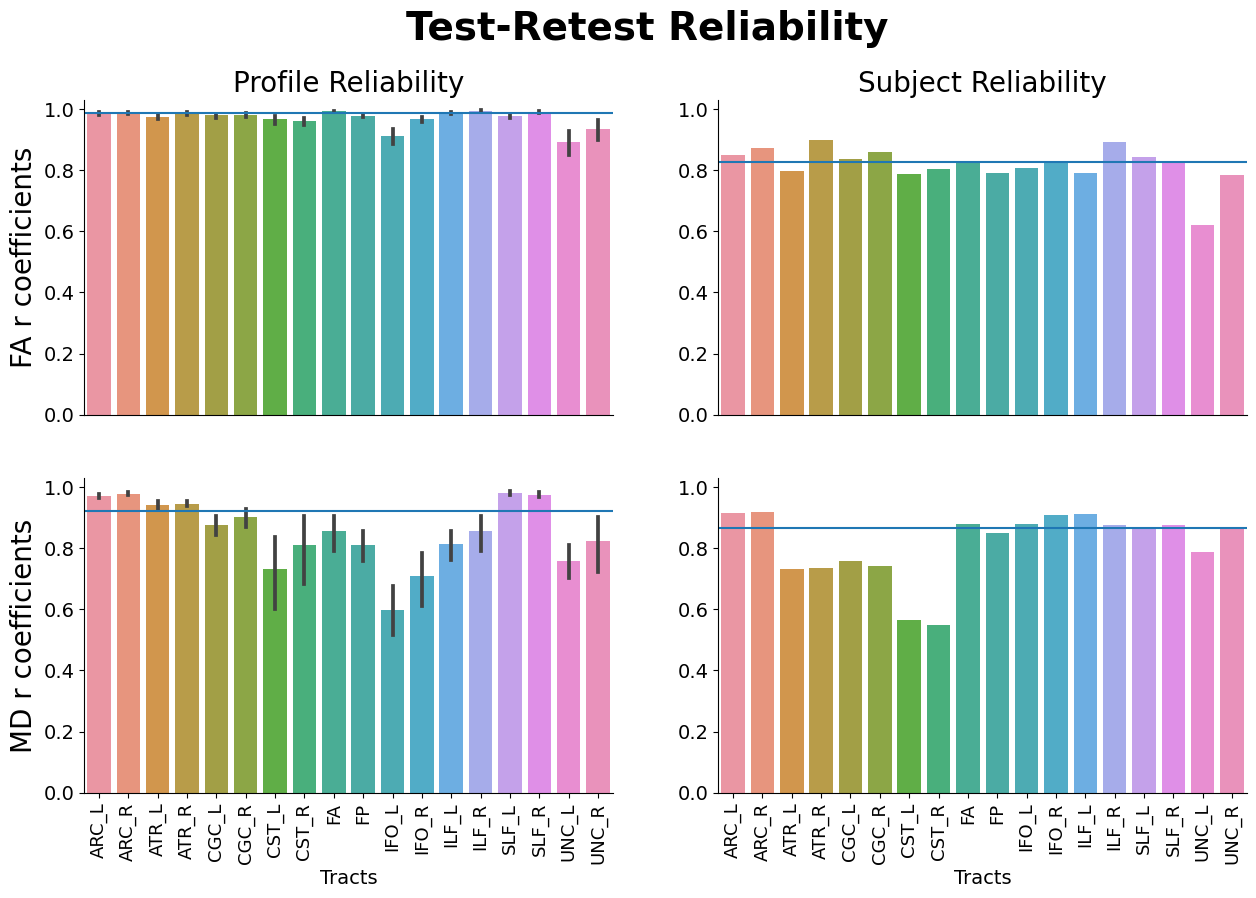

In [13]:
# Plot the histogram

fig, axes = plt.subplots(2, 2, figsize=(15, 9),sharey= False)
fig.suptitle('Test-Retest Reliability', weight='bold', fontsize= 28)
g = sns.barplot(x = df_TRR.tract, y = df_TRR.r_fa, ax = axes[0,0])
g.axhline(np.median(df_TRR_tract['r_fa']))
g.set_ylim((0,1.03))
g.set_ylabel('FA r coefficients', size =20)
g.set_xlabel(None)
g.set_yticklabels(g.get_yticklabels(), size = 14)
g.set_xticks([])
g.set_title('Profile Reliability', size = 20)
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)


p = sns.barplot(x = df_TRR.tract, y = df_TRR.r_md, ax = axes[1,0])
p.axhline(np.median(df_TRR_tract['r_md']))
p.set_ylim((0,1.03))
p.set_ylabel('MD r coefficients', size =20)
p.set_xlabel('Tracts', size = 14)
p.set_yticklabels(p.get_yticklabels(), size = 14)
p.set_xticklabels(p.get_xticklabels(), size = 13, rotation = 90)
p.spines['top'].set_visible(False)
p.spines['right'].set_visible(False)




a = sns.barplot(x = prek_TT_hist['tractID'], y = prek_TT_hist['r_fa'], ax = axes[0,1])
a.axhline(np.median(prek_TT_hist['r_fa']))
a.set_ylim((0,1.03))
a.set_xlabel(None)
a.set_ylabel(None)
a.set_yticklabels(a.get_yticklabels(), size = 14)
a.set_xticks([])
a.set_title('Subject Reliability', size = 20)
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
#a.get_yaxis().set_ticks([])

b = sns.barplot(x = prek_TT_hist['tractID'], y = prek_TT_hist['r_md'], ax = axes[1,1])
b.axhline(np.median(prek_TT_hist['r_md']))
b.set_ylim((0,1.03))
b.set_xlabel('Tracts', size = 14)
b.set_ylabel(None)
b.set_yticklabels(b.get_yticklabels(), size = 14)
b.set_xticklabels(b.get_xticklabels(), size = 13, rotation = 90)
b.spines['top'].set_visible(False)
b.spines['right'].set_visible(False)
#b.get_yaxis().set_ticks([])

#fig.tight_layout()
fig.show()

In [198]:
fig.savefig('TRR_results_clean_n35.tiff', format='tiff', dpi=1200)

# Median profile group comparison plots

In [14]:
#prek_file_clean 0 Letter
prek_file_clean['Group'] = prek_file_clean['Group'].replace(0, 'Letter')
prek_file_clean['Group'] = prek_file_clean['Group'].replace(1, 'Language')
prek_file_clean

,Unnamed_0,tractID,nodeID,dti_fa,dti_md,subjectID,sessionID,Group,dti_md_rescale
0,0,ATR_R,0,0.274050,0.000727,1103,post,Language,0.727200
1,1,ATR_R,1,0.292497,0.000739,1103,post,Language,0.738705
2,2,ATR_R,2,0.307782,0.000744,1103,post,Language,0.743912
3,3,ATR_R,3,0.321004,0.000745,1103,post,Language,0.745229
4,4,ATR_R,4,0.334779,0.000743,1103,post,Language,0.743166
...,...,...,...,...,...,...,...,...,...
169195,1795,FP,95,0.340846,0.000746,1964,pre,Letter,0.745814
169196,1796,FP,96,0.310727,0.000752,1964,pre,Letter,0.752337
169197,1797,FP,97,0.272333,0.000753,1964,pre,Letter,0.752860
169198,1798,FP,98,0.237698,0.000749,1964,pre,Letter,0.748912


### Get the median per subject and session (drop tract and node)

In [15]:
prek_file_clean_med = prek_file_clean.groupby(['tractID','subjectID','sessionID','Group'], as_index=False).agg({'dti_md_rescale':'median', 'dti_fa':'median'})
prek_file_clean_med

,tractID,subjectID,sessionID,Group,dti_md_rescale,dti_fa
0,ARC_L,1103,post,Language,0.702265,0.473157
1,ARC_L,1103,pre,Language,0.703374,0.515062
2,ARC_L,1110,post,Language,0.686993,0.533853
3,ARC_L,1110,pre,Language,0.694600,0.538360
4,ARC_L,1112,post,Letter,0.752636,0.479917
...,...,...,...,...,...,...
1255,UNC_R,1940,pre,Language,0.771288,0.429446
1256,UNC_R,1951,post,Letter,0.727157,0.491677
1257,UNC_R,1951,pre,Letter,0.734514,0.485252
1258,UNC_R,1964,post,Letter,0.775175,0.459552


## Left Arcuate

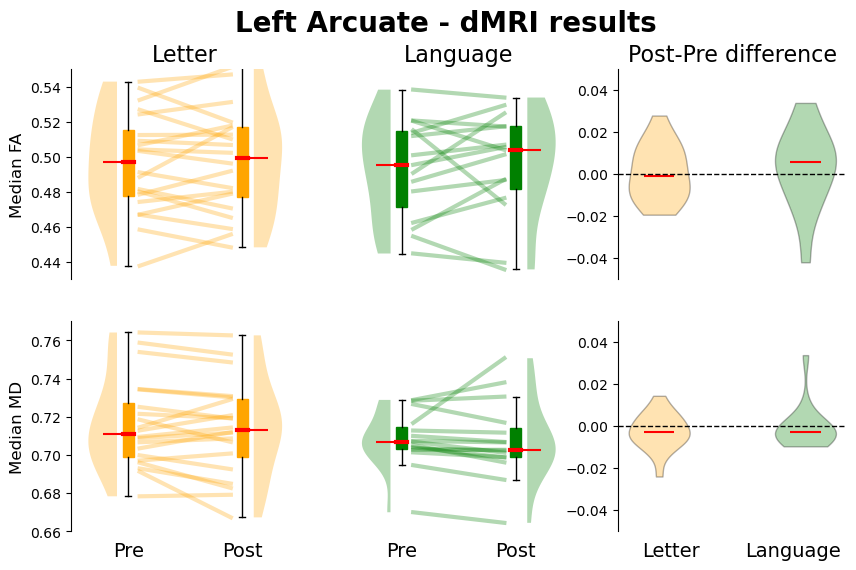

In [16]:
# create mini df
prek_file_clean_arc = prek_file_clean_med[prek_file_clean_med.tractID == 'ARC_L']
data_2tp_letter = prek_file_clean_arc[prek_file_clean_arc['Group'].isin(['Letter'])]
data_2tp_language = prek_file_clean_arc[prek_file_clean_arc['Group'].isin(['Language'])]


# define the hack function
def hack_violin(ax, side='left', color='blue'):
    for b in ax['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.set_facecolor(color)
        # modify the paths to not go further right than the center
        if side == 'left':
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
        else:
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)


# Create a figure and axes
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,6))
fig.suptitle('Left Arcuate - dMRI results', fontweight="bold", size = 20)

########################## FA ###########################
letter_pre = data_2tp_letter.dti_fa[data_2tp_letter['sessionID'].isin(['pre'])]
letter_post = data_2tp_letter.dti_fa[data_2tp_letter['sessionID'].isin(['post'])]
language_pre = data_2tp_language.dti_fa[data_2tp_language['sessionID'].isin(['pre'])]
language_post = data_2tp_language.dti_fa[data_2tp_language['sessionID'].isin(['post'])]


## letter plot 
# Combine violin plot, box plot, and line plot
violin_left = ax1.violinplot(letter_pre, positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax1.violinplot(letter_post, positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')

box = ax1.boxplot([letter_pre, letter_post], positions=[1, 2], patch_artist= True, widths=0.1, showfliers=False, boxprops=dict(facecolor='orange', color='orange'), medianprops=dict(color= 'red', linewidth=3))
line = ax1.plot([1.10, 1.9], np.array([letter_pre, letter_post]), color='orange', lw=3, alpha=0.3)

hack_violin(violin_left, side='left', color = 'orange')
hack_violin(violin_right, side='right', color = 'orange')

# Customize the plot
ax1.set_xticks([1, 2])
ax1.set_xticklabels([])
ax1.set_title('Letter', size = 16)
ax1.set_ylim([0.43,0.55])
#ax1.axis('off')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('Median FA', size = 12)
ax1.xaxis.set_ticks_position('none') 


## language plot
# Combine violin plot, box plot, and line plot
violin_left = ax2.violinplot(language_pre, positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax2.violinplot(language_post, positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')

box = ax2.boxplot([language_pre, language_post], positions=[1, 2], patch_artist= True, widths=0.1, showfliers=False, boxprops=dict(facecolor='green', color='green'), medianprops=dict(color='red', linewidth=3))
line = ax2.plot([1.10, 1.9], np.array([language_pre, language_post]), color='green', lw=3, alpha=0.3)

hack_violin(violin_left, side='left', color = 'green')
hack_violin(violin_right, side='right', color = 'green')

# Customize the plot
ax2.set_xticks([1, 2])
ax2.set_xticklabels([])
ax2.set_title('Language', size = 16)
ax2.set_ylim([0.43,0.55])
#ax2.axis('off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_ticks([])
ax2.set_ylabel('')
ax2.xaxis.set_ticks_position('none') 

violin_left = ax3.violinplot(pd.DataFrame(letter_post).reset_index(drop = True)-pd.DataFrame(letter_pre).reset_index(drop = True), positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax3.violinplot(pd.DataFrame(language_post).reset_index(drop = True)-pd.DataFrame(language_pre).reset_index(drop = True), positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
plt.setp(violin_left['bodies'], facecolor='orange', edgecolor='black')
plt.setp(violin_right['bodies'], facecolor='green', edgecolor='black')
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')
ax3.axhline(y=0.0, color='black', linestyle='--', linewidth=1) 
ax3.set_title('Post-Pre difference', size = 16)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.set_ylim([-0.05,0.05])
ax3.set_xticks([])

########################## MD ###########################
letter_pre = data_2tp_letter.dti_md_rescale[data_2tp_letter['sessionID'].isin(['pre'])]
letter_post = data_2tp_letter.dti_md_rescale[data_2tp_letter['sessionID'].isin(['post'])]
language_pre = data_2tp_language.dti_md_rescale[data_2tp_language['sessionID'].isin(['pre'])]
language_post = data_2tp_language.dti_md_rescale[data_2tp_language['sessionID'].isin(['post'])]


## letter plot 
# Combine violin plot, box plot, and line plot
violin_left = ax4.violinplot(letter_pre, positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax4.violinplot(letter_post, positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')

box = ax4.boxplot([letter_pre, letter_post], positions=[1, 2], patch_artist= True, widths=0.1, showfliers=False, boxprops=dict(facecolor='orange', color='orange'), medianprops=dict(color= 'red', linewidth=3))
line = ax4.plot([1.10, 1.9], np.array([letter_pre, letter_post]), color='orange', lw=3, alpha=0.3)

hack_violin(violin_left, side='left', color = 'orange')
hack_violin(violin_right, side='right', color = 'orange')

# Customize the plot
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Pre', 'Post'], size = 14)
ax4.set_ylim([0.66,0.77])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.set_ylabel('Median MD', size = 12)
ax4.xaxis.set_ticks_position('none') 


## language plot
# Combine violin plot, box plot, and line plot
violin_left = ax5.violinplot(language_pre, positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax5.violinplot(language_post, positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')

box = ax5.boxplot([language_pre, language_post], positions=[1, 2], patch_artist= True, widths=0.1, showfliers=False, boxprops=dict(facecolor='green', color='green'), medianprops=dict(color='red', linewidth=3))
line = ax5.plot([1.10, 1.9], np.array([language_pre, language_post]), color='green', lw=3, alpha=0.3)

hack_violin(violin_left, side='left', color = 'green')
hack_violin(violin_right, side='right', color = 'green')

# Customize the plot
ax5.set_xticks([1, 2])
ax5.set_xticklabels(['Pre', 'Post'], size = 14)
ax5.set_ylabel('Value')
ax5.set_ylim([0.66,0.77])
#ax2.axis('off')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.get_yaxis().set_ticks([])
ax5.set_ylabel('')
ax5.xaxis.set_ticks_position('none') 

violin_left = ax6.violinplot(pd.DataFrame(letter_post).reset_index(drop = True)-pd.DataFrame(letter_pre).reset_index(drop = True), positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax6.violinplot(pd.DataFrame(language_post).reset_index(drop = True)-pd.DataFrame(language_pre).reset_index(drop = True), positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
plt.setp(violin_left['bodies'], facecolor='orange', edgecolor='black')
plt.setp(violin_right['bodies'], facecolor='green', edgecolor='black')
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')
ax6.axhline(y=0.0, color='black', linestyle='--', linewidth=1) 
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['bottom'].set_visible(False)
ax6.set_ylim([-0.05,0.05])
ax6.set_xticks([1,2])
ax6.set_xticklabels(['Letter', 'Language'], size = 14)
ax6.xaxis.set_ticks_position('none') 

# Show the plot
plt.show()

In [36]:
fig.savefig('Left_Arcuate_clean_n35.tiff', format='tiff', dpi=1200)

## Left ILF

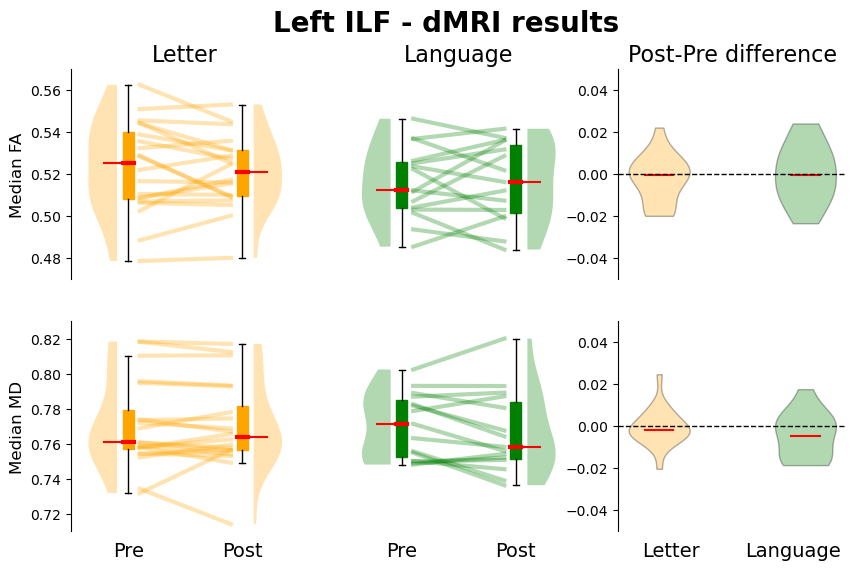

In [17]:
# create mini df
prek_file_clean_arc = prek_file_clean_med[prek_file_clean_med.tractID == 'ILF_L']
data_2tp_letter = prek_file_clean_arc[prek_file_clean_arc['Group'].isin(['Letter'])]
data_2tp_language = prek_file_clean_arc[prek_file_clean_arc['Group'].isin(['Language'])]


# define the hack function
def hack_violin(ax, side='left', color='blue'):
    for b in ax['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.set_facecolor(color)
        # modify the paths to not go further right than the center
        if side == 'left':
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
        else:
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)


# Create a figure and axes
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,6))
fig.suptitle('Left ILF - dMRI results', fontweight="bold", size = 20)

########################## FA ###########################
letter_pre = data_2tp_letter.dti_fa[data_2tp_letter['sessionID'].isin(['pre'])]
letter_post = data_2tp_letter.dti_fa[data_2tp_letter['sessionID'].isin(['post'])]
language_pre = data_2tp_language.dti_fa[data_2tp_language['sessionID'].isin(['pre'])]
language_post = data_2tp_language.dti_fa[data_2tp_language['sessionID'].isin(['post'])]


## letter plot 
# Combine violin plot, box plot, and line plot
violin_left = ax1.violinplot(letter_pre, positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax1.violinplot(letter_post, positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')

box = ax1.boxplot([letter_pre, letter_post], positions=[1, 2], patch_artist= True, widths=0.1, showfliers=False, boxprops=dict(facecolor='orange', color='orange'), medianprops=dict(color= 'red', linewidth=3))
line = ax1.plot([1.10, 1.9], np.array([letter_pre, letter_post]), color='orange', lw=3, alpha=0.3)

hack_violin(violin_left, side='left', color = 'orange')
hack_violin(violin_right, side='right', color = 'orange')

# Customize the plot
ax1.set_xticks([1, 2])
ax1.set_xticklabels([])
ax1.set_title('Letter', size = 16)
ax1.set_ylim([0.47,0.57])
#ax1.axis('off')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('Median FA', size = 12)
ax1.xaxis.set_ticks_position('none') 


## language plot
# Combine violin plot, box plot, and line plot
violin_left = ax2.violinplot(language_pre, positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax2.violinplot(language_post, positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')

box = ax2.boxplot([language_pre, language_post], positions=[1, 2], patch_artist= True, widths=0.1, showfliers=False, boxprops=dict(facecolor='green', color='green'), medianprops=dict(color='red', linewidth=3))
line = ax2.plot([1.10, 1.9], np.array([language_pre, language_post]), color='green', lw=3, alpha=0.3)

hack_violin(violin_left, side='left', color = 'green')
hack_violin(violin_right, side='right', color = 'green')

# Customize the plot
ax2.set_xticks([1, 2])
ax2.set_xticklabels([])
ax2.set_title('Language', size = 16)
ax2.set_ylim([0.47,0.57])
#ax2.axis('off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_ticks([])
ax2.set_ylabel('')
ax2.xaxis.set_ticks_position('none') 

violin_left = ax3.violinplot(pd.DataFrame(letter_post).reset_index(drop = True)-pd.DataFrame(letter_pre).reset_index(drop = True), positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax3.violinplot(pd.DataFrame(language_post).reset_index(drop = True)-pd.DataFrame(language_pre).reset_index(drop = True), positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
plt.setp(violin_left['bodies'], facecolor='orange', edgecolor='black')
plt.setp(violin_right['bodies'], facecolor='green', edgecolor='black')
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')
ax3.axhline(y=0.0, color='black', linestyle='--', linewidth=1) 
ax3.set_title('Post-Pre difference', size = 16)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.set_ylim([-0.05,0.05])
ax3.set_xticks([])

########################## MD ###########################
letter_pre = data_2tp_letter.dti_md_rescale[data_2tp_letter['sessionID'].isin(['pre'])]
letter_post = data_2tp_letter.dti_md_rescale[data_2tp_letter['sessionID'].isin(['post'])]
language_pre = data_2tp_language.dti_md_rescale[data_2tp_language['sessionID'].isin(['pre'])]
language_post = data_2tp_language.dti_md_rescale[data_2tp_language['sessionID'].isin(['post'])]


## letter plot 
# Combine violin plot, box plot, and line plot
violin_left = ax4.violinplot(letter_pre, positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax4.violinplot(letter_post, positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')

box = ax4.boxplot([letter_pre, letter_post], positions=[1, 2], patch_artist= True, widths=0.1, showfliers=False, boxprops=dict(facecolor='orange', color='orange'), medianprops=dict(color= 'red', linewidth=3))
line = ax4.plot([1.10, 1.9], np.array([letter_pre, letter_post]), color='orange', lw=3, alpha=0.3)

hack_violin(violin_left, side='left', color = 'orange')
hack_violin(violin_right, side='right', color = 'orange')

# Customize the plot
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Pre', 'Post'], size = 14)
ax4.set_ylim([0.71,0.83])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.set_ylabel('Median MD', size = 12)
ax4.xaxis.set_ticks_position('none') 


## language plot
# Combine violin plot, box plot, and line plot
violin_left = ax5.violinplot(language_pre, positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax5.violinplot(language_post, positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')

box = ax5.boxplot([language_pre, language_post], positions=[1, 2], patch_artist= True, widths=0.1, showfliers=False, boxprops=dict(facecolor='green', color='green'), medianprops=dict(color='red', linewidth=3))
line = ax5.plot([1.10, 1.9], np.array([language_pre, language_post]), color='green', lw=3, alpha=0.3)

hack_violin(violin_left, side='left', color = 'green')
hack_violin(violin_right, side='right', color = 'green')

# Customize the plot
ax5.set_xticks([1, 2])
ax5.set_xticklabels(['Pre', 'Post'], size = 14)
ax5.set_ylim([0.71,0.83])
#ax2.axis('off')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.get_yaxis().set_ticks([])
ax5.set_ylabel('')
ax5.xaxis.set_ticks_position('none') 

violin_left = ax6.violinplot(pd.DataFrame(letter_post).reset_index(drop = True)-pd.DataFrame(letter_pre).reset_index(drop = True), positions=[0.9], showmedians=True, showextrema=False, widths=0.5)
violin_right = ax6.violinplot(pd.DataFrame(language_post).reset_index(drop = True)-pd.DataFrame(language_pre).reset_index(drop = True), positions=[2.1], showmedians=True, showextrema=False, widths=0.5)
plt.setp(violin_left['bodies'], facecolor='orange', edgecolor='black')
plt.setp(violin_right['bodies'], facecolor='green', edgecolor='black')
violin_left['cmedians'].set_colors('red')
violin_right['cmedians'].set_colors('red')
ax6.axhline(y=0.0, color='black', linestyle='--', linewidth=1) 
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['bottom'].set_visible(False)
ax6.set_ylim([-0.05,0.05])
ax6.set_xticks([1,2])
ax6.set_xticklabels(['Letter', 'Language'], size = 14)
ax6.xaxis.set_ticks_position('none') 

# Show the plot
plt.show()

In [41]:
fig.savefig('Left_ILF_clean_n35.tiff', format='tiff', dpi=1200)

# Plot bundles

In [18]:
# get a new dataframe including SE values for each tract and node
node_list= range(100)
tract_list = np.unique(prek_file.tractID)
session_list= ['pre','post']
prek_clean_SE = pd.DataFrame(columns = ['tractID','nodeID','mean_fa','mean_md','SE_fa','SE_md','sessionID','groupID'])

for group in range(2):
    for ses in session_list:
        for tract in tract_list:
            for node in node_list:
                prek_group = prek_file[prek_file.Group == group]
                prek_ses = prek_group[prek_group.sessionID == ses]
                prek_tract = prek_ses[prek_ses.tractID == tract]
                prek_node = prek_tract[prek_tract.nodeID == node]
                SE_md = sem(prek_node.dti_md_rescale)
                SE_fa = sem(prek_node.dti_fa)
                mean_md = np.mean(prek_node.dti_md_rescale)
                mean_fa = np.mean(prek_node.dti_fa)
                mini_df = pd.DataFrame([[tract,node,mean_fa,mean_md,SE_fa,SE_md,ses,group]],columns = ['tractID','nodeID','mean_fa','mean_md','SE_fa','SE_md','sessionID','groupID'])
                prek_clean_SE = prek_clean_SE.append(mini_df)

In [19]:
prek_clean_SE

,tractID,nodeID,mean_fa,mean_md,SE_fa,SE_md,sessionID,groupID
0,ARC_L,0,0.263990,0.787343,0.004604,0.004955,pre,0
0,ARC_L,1,0.298707,0.790368,0.004450,0.004934,pre,0
0,ARC_L,2,0.331308,0.783087,0.004311,0.004766,pre,0
0,ARC_L,3,0.358928,0.772718,0.004288,0.004649,pre,0
0,ARC_L,4,0.381570,0.762837,0.004412,0.004673,pre,0
...,...,...,...,...,...,...,...,...
0,UNC_R,95,0.339217,0.776737,0.006285,0.003771,post,1
0,UNC_R,96,0.326544,0.776456,0.006448,0.003858,post,1
0,UNC_R,97,0.311566,0.773703,0.006688,0.004110,post,1
0,UNC_R,98,0.294559,0.767173,0.007096,0.004607,post,1


In [20]:
# Add a new column containing group and session
prek_clean_SE.loc[(prek_clean_SE.groupID == 0) & (prek_clean_SE.sessionID == 'pre'), 'groupID_sessionID']='let_pre'
prek_clean_SE.loc[(prek_clean_SE.groupID == 0) & (prek_clean_SE.sessionID == 'post'), 'groupID_sessionID']='let_post'
prek_clean_SE.loc[(prek_clean_SE.groupID == 1) & (prek_clean_SE.sessionID == 'pre'), 'groupID_sessionID']='lan_pre'
prek_clean_SE.loc[(prek_clean_SE.groupID == 1) & (prek_clean_SE.sessionID == 'post'), 'groupID_sessionID']='lan_post'
prek_clean_SE

,tractID,nodeID,mean_fa,mean_md,SE_fa,SE_md,sessionID,groupID,groupID_sessionID
0,ARC_L,0,0.263990,0.787343,0.004604,0.004955,pre,0,let_pre
0,ARC_L,1,0.298707,0.790368,0.004450,0.004934,pre,0,let_pre
0,ARC_L,2,0.331308,0.783087,0.004311,0.004766,pre,0,let_pre
0,ARC_L,3,0.358928,0.772718,0.004288,0.004649,pre,0,let_pre
0,ARC_L,4,0.381570,0.762837,0.004412,0.004673,pre,0,let_pre
...,...,...,...,...,...,...,...,...,...
0,UNC_R,95,0.339217,0.776737,0.006285,0.003771,post,1,lan_post
0,UNC_R,96,0.326544,0.776456,0.006448,0.003858,post,1,lan_post
0,UNC_R,97,0.311566,0.773703,0.006688,0.004110,post,1,lan_post
0,UNC_R,98,0.294559,0.767173,0.007096,0.004607,post,1,lan_post


## MD

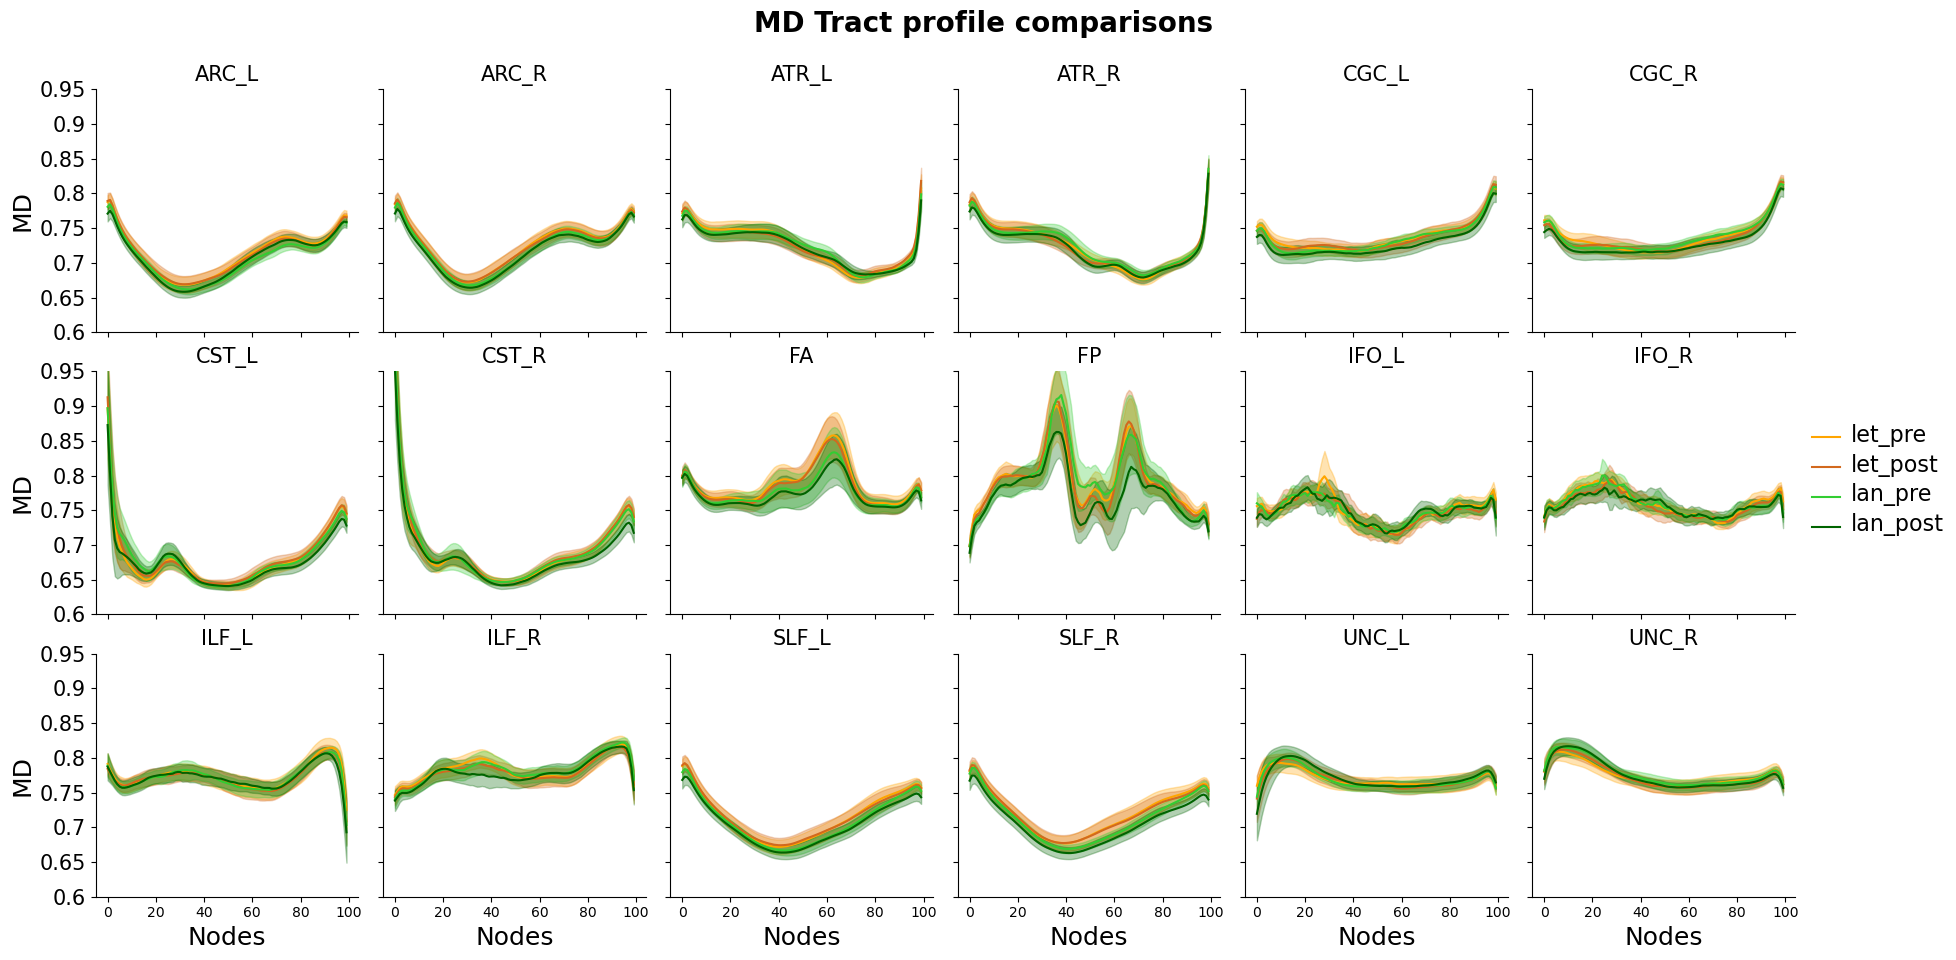

In [21]:
# number of SE to plot
n_SE=2

# Main plot with tract profiles
g = sns.FacetGrid(prek_clean_SE, col="tractID", 
                  col_wrap=6,hue='groupID_sessionID', palette = ['orange','chocolate','limegreen','darkgreen'])
g.map(sns.lineplot, "nodeID",'mean_md')
g.set_ylabels('MD', size = 18)
g.set_xlabels('Nodes', size = 18)
g.set(ylim=(0.6,0.95))
g.fig.suptitle('MD Tract profile comparisons',fontsize=20, fontweight="bold", y = 1.05)

# Legend
g.add_legend()
# Legend title
g.legend.set_title(None)
# Legend texts
for text in g.legend.texts:
    text.set_fontsize(16)


# Add shaded areas
for col_val, ax in g.axes_dict.items():
    prek_tract = prek_clean_SE[prek_clean_SE['tractID'] == col_val]
    nodes = prek_clean_SE['nodeID'].unique().tolist()
    
    let = prek_tract[prek_tract.groupID==0]
    let_pre = let[let.sessionID == 'pre']
    lower_let_pre = let_pre.mean_md - n_SE*let_pre.SE_md
    upper_let_pre = let_pre.mean_md + n_SE*let_pre.SE_md
    ax.fill_between(nodes,lower_let_pre, upper_let_pre, alpha=0.3, color = 'orange')
             
    let_post = let[let.sessionID == 'post']
    lower_let_post = let_post.mean_md - n_SE*let_post.SE_md
    upper_let_post = let_post.mean_md + n_SE*let_post.SE_md
    ax.fill_between(nodes,lower_let_post, upper_let_post, alpha=0.3, color = 'chocolate')
    
    
    lan = prek_tract[prek_tract.groupID==1]
    lan_pre = lan[lan.sessionID == 'pre']
    lower_lan_pre = lan_pre.mean_md - n_SE*lan_pre.SE_md
    upper_lan_pre = lan_pre.mean_md + n_SE*lan_pre.SE_md
    ax.fill_between(nodes,lower_lan_pre, upper_lan_pre, alpha=0.3, color = 'limegreen')
             
    lan_post = lan[lan.sessionID == 'post']
    lower_lan_post = lan_post.mean_md - n_SE*lan_post.SE_md
    upper_lan_post = lan_post.mean_md + n_SE*lan_post.SE_md
    ax.fill_between(nodes,lower_lan_post, upper_lan_post, alpha=0.3, color = 'darkgreen')
    
    ax.set_yticklabels([0.60,0.65,0.70,0.75,0.80,0.85,0.90, 0.95], size = 15)
    ax.set_title(col_val, size = 15)
    


In [106]:
g.savefig('MD_Tract_profiles_clean_n35.tiff', format='tiff', dpi=1200)

## FA

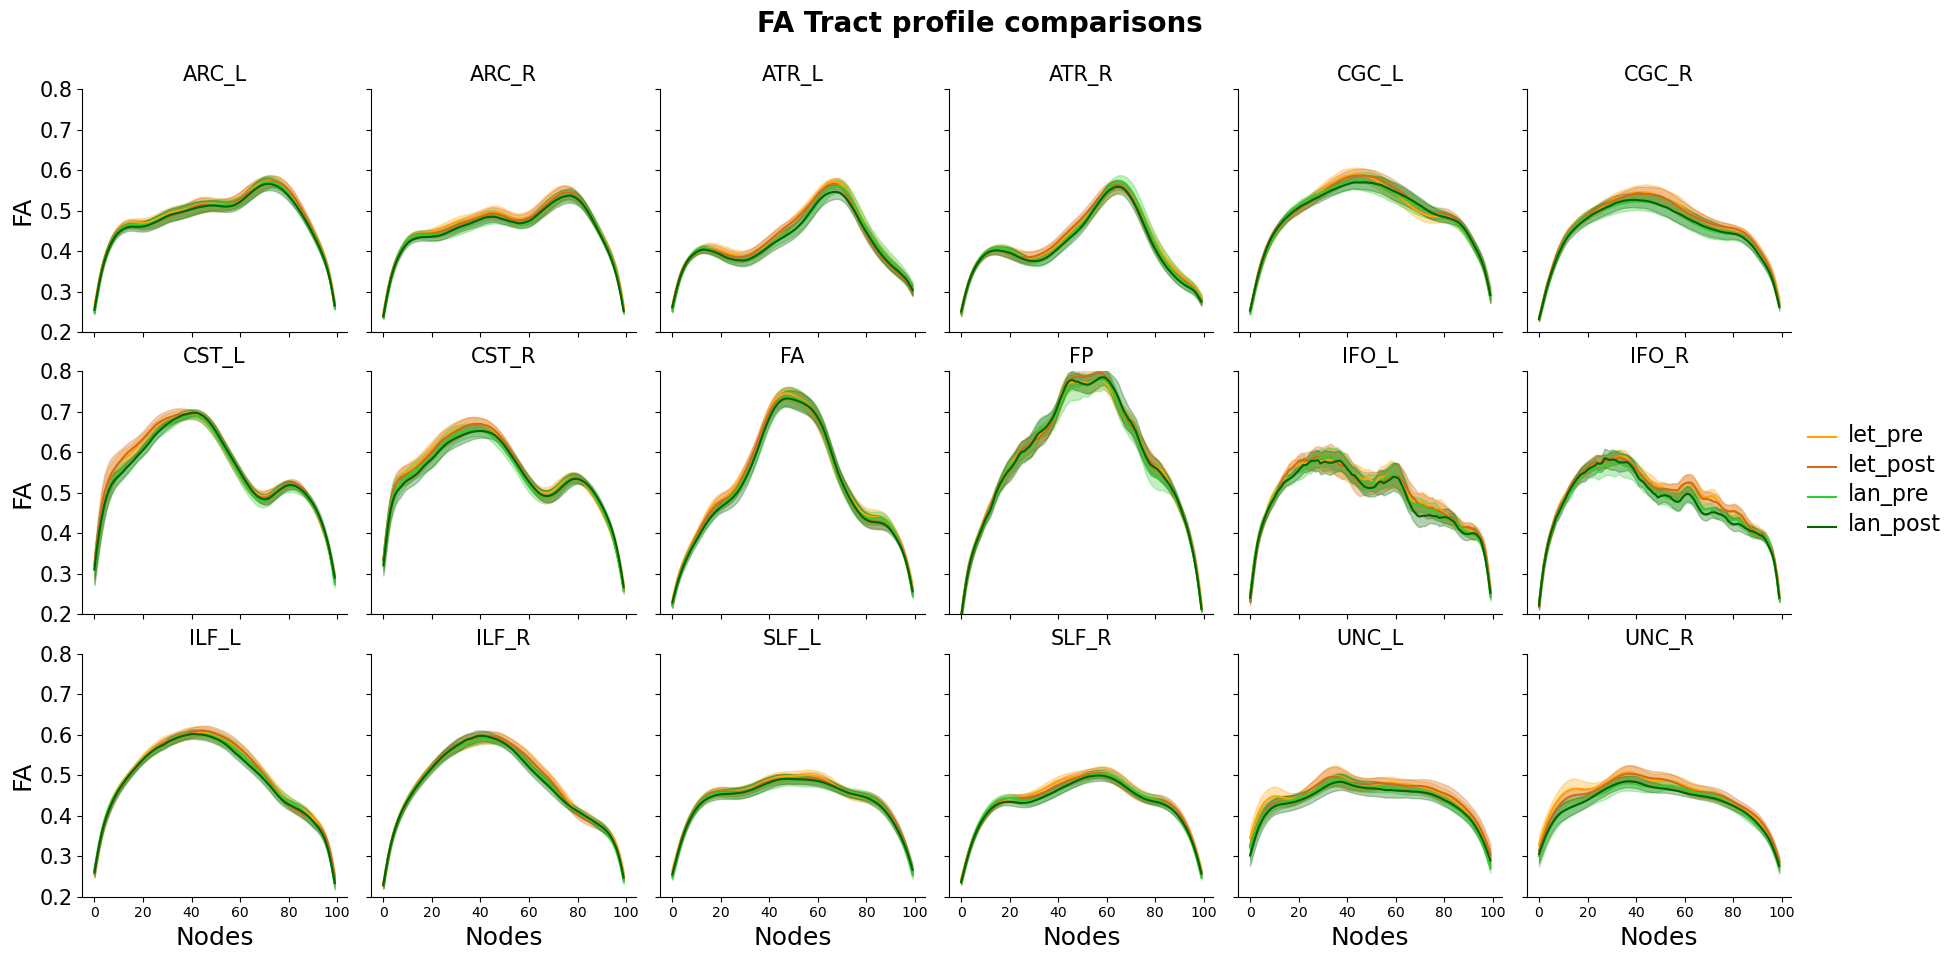

In [22]:
# number of SE to plot
n_SE=2

# Main plot with tract profiles
g = sns.FacetGrid(prek_clean_SE, col="tractID", 
                  col_wrap=6,hue='groupID_sessionID', palette = ['orange','chocolate','limegreen','darkgreen'])
g.map(sns.lineplot, "nodeID",'mean_fa')
g.set_ylabels('FA', size = 18)
g.set_xlabels('Nodes', size = 18)
g.set(ylim=(0.2,0.8))
g.fig.suptitle('FA Tract profile comparisons',fontsize=20, fontweight="bold", y = 1.05)

# Legend
g.add_legend()
# Legend title
g.legend.set_title(None)
# Legend texts
for text in g.legend.texts:
    text.set_fontsize(16)


# Add shaded areas
for col_val, ax in g.axes_dict.items():
    prek_tract = prek_clean_SE[prek_clean_SE['tractID'] == col_val]
    nodes = prek_clean_SE['nodeID'].unique().tolist()
    
    let = prek_tract[prek_tract.groupID==0]
    let_pre = let[let.sessionID == 'pre']
    lower_let_pre = let_pre.mean_fa - n_SE*let_pre.SE_fa
    upper_let_pre = let_pre.mean_fa + n_SE*let_pre.SE_fa
    ax.fill_between(nodes,lower_let_pre, upper_let_pre, alpha=0.3, color = 'orange')
             
    let_post = let[let.sessionID == 'post']
    lower_let_post = let_post.mean_fa - n_SE*let_post.SE_fa
    upper_let_post = let_post.mean_fa + n_SE*let_post.SE_fa
    ax.fill_between(nodes,lower_let_post, upper_let_post, alpha=0.3, color = 'chocolate')
    
    
    lan = prek_tract[prek_tract.groupID==1]
    lan_pre = lan[lan.sessionID == 'pre']
    lower_lan_pre = lan_pre.mean_fa - n_SE*lan_pre.SE_fa
    upper_lan_pre = lan_pre.mean_fa + n_SE*lan_pre.SE_fa
    ax.fill_between(nodes,lower_lan_pre, upper_lan_pre, alpha=0.3, color = 'limegreen')
             
    lan_post = lan[lan.sessionID == 'post']
    lower_lan_post = lan_post.mean_fa - n_SE*lan_post.SE_fa
    upper_lan_post = lan_post.mean_fa + n_SE*lan_post.SE_fa
    ax.fill_between(nodes,lower_lan_post, upper_lan_post, alpha=0.3, color = 'darkgreen')
    
    ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7,0.8], size = 15)
    ax.set_title(col_val, size = 15)

In [104]:
g.savefig('FA_Tract_profiles_clean_n35.tiff', format='tiff', dpi=1200)

In [20]:
#  Get only a few tracts
tract_list = ['ARC_L','UNC_L','UNC_R']
prek_clean_SE_sub = prek_clean_SE[prek_clean_SE.tractID.isin(tract_list)]
prek_clean_SE_sub

,tractID,nodeID,mean_fa,mean_md,SE_fa,SE_md,sessionID,groupID,groupID_sessionID
0,ARC_L,0,0.263990,0.787343,0.004604,0.004955,pre,0,let_pre
0,ARC_L,1,0.298707,0.790368,0.004450,0.004934,pre,0,let_pre
0,ARC_L,2,0.331308,0.783087,0.004311,0.004766,pre,0,let_pre
0,ARC_L,3,0.358928,0.772718,0.004288,0.004649,pre,0,let_pre
0,ARC_L,4,0.381570,0.762837,0.004412,0.004673,pre,0,let_pre
...,...,...,...,...,...,...,...,...,...
0,UNC_R,95,0.339217,0.776737,0.006285,0.003771,post,1,lan_post
0,UNC_R,96,0.326544,0.776456,0.006448,0.003858,post,1,lan_post
0,UNC_R,97,0.311566,0.773703,0.006688,0.004110,post,1,lan_post
0,UNC_R,98,0.294559,0.767173,0.007096,0.004607,post,1,lan_post


Text(0.5, 1.05, 'Tract Profiles')

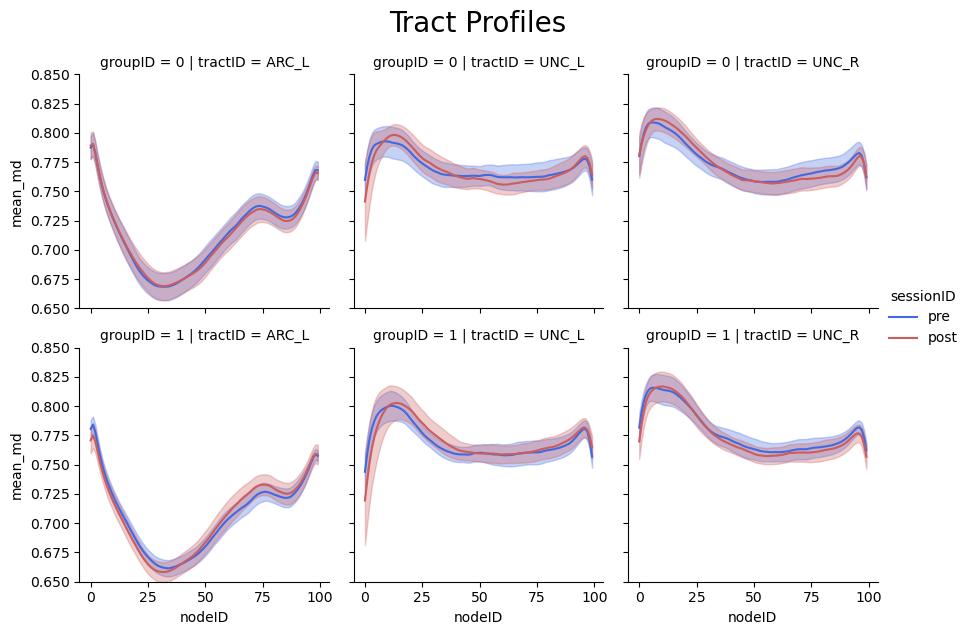

In [21]:
# number of SE to plot
n_SE=2

# Main plot with tract profiles
g = sns.FacetGrid(prek_clean_SE_sub, col="tractID", 
                  row='groupID',hue='sessionID', palette = ['royalblue','indianred'])
g.map(sns.lineplot, "nodeID",'mean_md')
g.add_legend()
g.set(ylim=(0.65,0.85))

# Add shaded areas
for col_val, ax in g.axes_dict.items():
        prek_group = prek_clean_SE_sub[prek_clean_SE_sub['groupID'] == col_val[0]]
        prek_tract = prek_group[prek_group['tractID'] == col_val[1]]
        nodes = prek_clean_SE_sub['nodeID'].unique().tolist()

        pre = prek_tract[prek_tract.sessionID == 'pre']
        lower_pre = pre.mean_md - n_SE*pre.SE_md
        upper_pre = pre.mean_md + n_SE*pre.SE_md
        ax.fill_between(nodes,lower_pre, upper_pre, alpha=0.3, color = 'royalblue')
        
        post = prek_tract[prek_tract.sessionID == 'post']  
        lower_post = post.mean_md - n_SE*post.SE_md
        upper_post = post.mean_md + n_SE*post.SE_md
        ax.fill_between(nodes,lower_post, upper_post, alpha=0.3, color = 'indianred')
    
g.fig.suptitle('Tract Profiles',fontsize=20, y = 1.05)

# LME

In [23]:
# deviation coding

levels = [1,2]
contrast = Sum().code_without_intercept(levels)
print(contrast.matrix)

[[ 1.]
 [-1.]]


## Model on the median scalar values of the all tract

### MD

In [24]:
# keep track of the t and p values for the interaction
tract_list = np.unique(prek_file.tractID)
stats_t = np.zeros((len(tract_list)))
stats_p = np.zeros((len(tract_list)))
stats_bic = np.zeros((len(tract_list)))

    
# Run a LME for each tract
for tck,tract in zip(range(0,len(tract_list)),tract_list):
    prek_sub = prek_file[prek_file.tractID == tract]
    prek_md = prek_sub.groupby(['subjectID','sessionID','Group'], as_index=False).agg({'dti_md_rescale':'mean'})
    # LME Group x session with by-sj random intercept
    md = smf.mixedlm("dti_md_rescale ~ C(sessionID,Sum)*C(Group,Sum)", prek_md, groups= 'subjectID') # , re_formula="~C(sessionID)") # vc_formula={"sessionID":"0+C(sessionID,Sum)"}) #re_formula="~C(sessionID,Sum)")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        mdf = md.fit()
        if mdf.converged == True:
            #print(mdf.summary())
            # stats of the interaction
            stats_t[tck]= mdf.tvalues[3] # 1 main effect of session, 2 for main effect of Group and 3 interaction
            stats_p[tck]= mdf.pvalues[3]
            stats_bic[tck]= -2 * mdf.llf + np.log(mdf.nobs) * (mdf.df_modelwc)


### FA

In [36]:
# keep track of the t and p values for the interaction
tract_list = np.unique(prek_file.tractID)
stats_t = np.zeros((len(tract_list)))
stats_p = np.zeros((len(tract_list)))
stats_bic = np.zeros((len(tract_list)))

    
# Run a LME for each tract
for tck,tract in zip(range(0,len(tract_list)),tract_list):
    prek_sub = prek_file[prek_file.tractID == tract]
    prek_fa = prek_sub.groupby(['subjectID','sessionID','Group'], as_index=False).agg({'dti_fa':'mean'})
    # LME Group x session with by-sj random intercept
    md = smf.mixedlm("dti_fa ~ C(sessionID,Sum)*C(Group,Sum)", prek_fa, groups= 'subjectID') # , re_formula="~C(sessionID)") # vc_formula={"sessionID":"0+C(sessionID,Sum)"}) #re_formula="~C(sessionID,Sum)")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        mdf = md.fit()
        if mdf.converged == True:
            #print(mdf.summary())
            # stats of the interaction
            stats_t[tck]= mdf.tvalues[3] # 1 main effect of session, 2 for main effect of Group and 3 interaction
            stats_p[tck]= mdf.pvalues[3]
            stats_bic[tck]= -2 * mdf.llf + np.log(mdf.nobs) * (mdf.df_modelwc)

## Model on each node of the tract

In [151]:
node_list = range(100)
tract_list = np.unique(prek_file.tractID)
stats_t = np.zeros((len(node_list),len(tract_list)))
stats_p = np.zeros((len(node_list),len(tract_list)))

for trk,tract in zip(range(0,len(tract_list)),tract_list):
    prek_sub = prek_file[prek_file.tractID == tract]
    for node in node_list:
        prek_node = prek_sub[prek_sub.nodeID == node]
        # LME Group x session with by-sj random intercept
        md = smf.mixedlm("dti_md_rescale ~ C(sessionID,Sum)*C(Group,Sum)", prek_node, groups= 'subjectID')#, vc_formula={"sessionID":"0+C(sessionID,Sum)"}) #re_formula="~C(sessionID,Sum)")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ConvergenceWarning)
            mdf = md.fit()
            if mdf.converged == True:
                #print(mdf.summary())
                # stats of the interaction
                stats_t[node,trk] = mdf.tvalues[3] # 2 for main effect of Group
                stats_p[node,trk] = mdf.pvalues[3]
  

## Post-pre differences

In [153]:
# get post pre subsets
pre = prek_file[prek_file.sessionID == 'pre'].reset_index()
post = prek_file[prek_file.sessionID == 'post'].reset_index()

# get the list of subjects that are common between pre and post session
comm_sj = np.unique(pre.subjectID[pre.subjectID.isin(post.subjectID)])

# subset the database only with those subjects
prek_sj = prek_file[prek_file.subjectID.isin(comm_sj)]
prek_sj

,Unnamed_0,tractID,nodeID,dti_fa,dti_md,subjectID,sessionID,Group,dti_md_rescale
0,0,ATR_R,0,0.274050,0.000727,1103,post,1,0.727200
1,1,ATR_R,1,0.292497,0.000739,1103,post,1,0.738705
2,2,ATR_R,2,0.307782,0.000744,1103,post,1,0.743912
3,3,ATR_R,3,0.321004,0.000745,1103,post,1,0.745229
4,4,ATR_R,4,0.334779,0.000743,1103,post,1,0.743166
...,...,...,...,...,...,...,...,...,...
169195,1795,FP,95,0.340846,0.000746,1964,pre,0,0.745814
169196,1796,FP,96,0.310727,0.000752,1964,pre,0,0.752337
169197,1797,FP,97,0.272333,0.000753,1964,pre,0,0.752860
169198,1798,FP,98,0.237698,0.000749,1964,pre,0,0.748912


In [154]:
print('Number of common participants across sessions: ' + str(len(np.unique(prek_sj.subjectID))))
print('Number of common participants in Language group: ' + str(len(np.unique(prek_sj.subjectID[prek_sj.Group == 1]))))
print('Number of common participants in Letter group: ' + str(len(np.unique(prek_sj.subjectID[prek_sj.Group == 0]))))

Number of common participants across sessions: 35
Number of common participants in Language group: 15
Number of common participants in Letter group: 20


In [155]:
# get post-pre differences
pre = prek_sj[prek_sj.sessionID == 'pre'].reset_index()
post = prek_sj[prek_sj.sessionID == 'post'].reset_index()

# calculate the difference
diff_md = post.dti_md_rescale-pre.dti_md_rescale
diff_fa = post.dti_fa-pre.dti_fa

# get the new dataframe
prek_diff= pre.drop(columns=['dti_md','dti_fa','sessionID','index','dti_md_rescale'], axis=1)
prek_diff['diff_md']=diff_md
prek_diff['diff_fa']=diff_fa
prek_diff

,Unnamed_0,tractID,nodeID,subjectID,Group,diff_md,diff_fa
0,0,ATR_R,0,1103,1,-0.052639,0.028255
1,1,ATR_R,1,1103,1,-0.045454,0.017536
2,2,ATR_R,2,1103,1,-0.038479,0.004822
3,3,ATR_R,3,1103,1,-0.032556,-0.004907
4,4,ATR_R,4,1103,1,-0.029353,-0.010046
...,...,...,...,...,...,...,...
62995,1795,FP,95,1964,0,-0.023003,0.011181
62996,1796,FP,96,1964,0,-0.026718,0.017287
62997,1797,FP,97,1964,0,-0.026958,0.023628
62998,1798,FP,98,1964,0,-0.029719,0.013607


### Add SE 

In [157]:
# get a new dataframe including median and SE values for each tract and node
node_list= range(100)
tract_list = np.unique(prek_diff.tractID)
prek_diff_SE = pd.DataFrame(columns = ['tractID','nodeID','groupID', 'mean_md','mean_fa','SE_md','SE_fa'])

for group in range(2):
    for tract in tract_list:
        for node in node_list:
            prek_group = prek_diff[prek_diff.Group == group]
            prek_tract = prek_group[prek_group.tractID == tract]
            prek_node = prek_tract[prek_tract.nodeID == node]
            SE_md = sem(prek_node.diff_md)
            SE_fa = sem(prek_node.diff_fa)
            mean_md = np.mean(prek_node.diff_md)
            mean_fa = np.mean(prek_node.diff_fa)
            mini_df = pd.DataFrame([[tract,node,group,mean_md,mean_fa,SE_md,SE_fa]],columns = ['tractID','nodeID','groupID','mean_md','mean_fa','SE_md','SE_fa'])
            prek_diff_SE = prek_diff_SE.append(mini_df)


In [158]:
prek_diff_SE = prek_diff_SE.reset_index(drop = True)
prek_diff_SE

,tractID,nodeID,groupID,mean_md,mean_fa,SE_md,SE_fa
0,ARC_L,0,0,0.002224,-0.006297,0.003057,0.003190
1,ARC_L,1,0,0.001031,-0.004355,0.002735,0.003021
2,ARC_L,2,0,0.000380,-0.002744,0.002533,0.002864
3,ARC_L,3,0,0.000253,-0.002124,0.002458,0.002722
4,ARC_L,4,0,0.000548,-0.001468,0.002425,0.002731
...,...,...,...,...,...,...,...
3595,UNC_R,95,1,-0.007255,0.001805,0.003177,0.005538
3596,UNC_R,96,1,-0.007346,0.001260,0.003490,0.005837
3597,UNC_R,97,1,-0.007128,0.000668,0.004091,0.005997
3598,UNC_R,98,1,-0.006321,0.000337,0.004972,0.006074


## LME on post-pre differences

### T-tests and bayesian analyses on full tracts

In [160]:
# All tracts MD
# keep track of the t and p values for the interaction
tract_list = np.unique(prek_file.tractID)
stats_t = np.zeros((len(tract_list)))
stats_p = np.zeros((len(tract_list)))
stats_bf = np.zeros((len(tract_list)))
    
# Run a LME for each tract
for trk,tract in zip(range(0,len(tract_list)),tract_list):
    prek_sub = prek_diff[prek_diff.tractID == tract]
    prek_md = prek_sub.groupby(['subjectID','Group'], as_index=False).agg({'diff_md':'mean'})
    let = prek_md.diff_md[prek_md.Group == 0]
    lan = prek_md.diff_md[prek_md.Group == 1]
    # Independent two tailed t test for each tract
    tt= ttest_ind(let, lan)
    # Bayesian analyses in R with BayesFactor package
    # import the data frames into the R workspace
    robjects.globalenv["let"] = let
    robjects.globalenv["lan"] = lan

    
    # compute the Bayes factor
    r('bf = ttestBF(x=let,y=lan)') # if one-tailed nullInterval = c(0,Inf)
    bf = r('as.vector(bf)')
    # stats for group effect
    stats_t[trk]= tt[0]
    stats_p[trk]= tt[1]
    stats_bf[trk]= bf[0]

In [60]:
# Stats by node
node_list=range(100)
tract_list=np.unique(prek_diff.tractID)
stats_t = np.zeros((len(node_list),len(tract_list)))
stats_p = np.zeros((len(node_list),len(tract_list)))

for trk,tract in zip(range(0,len(tract_list)),tract_list):
    prek_sub = prek_diff[prek_diff.tractID==tract]
    for node in node_list:
        prek_node=prek_sub[prek_sub.nodeID==node]
        # Independent t test per each node
        tt= ttest_ind(prek_node.diff_md[prek_node.Group == 0], prek_node.diff_md[prek_node.Group == 1])
        # stats of the interaction
        stats_t[node,trk]= tt[0]
        stats_p[node,trk]= tt[1]

## Same for FA

In [163]:
# All tracts FA
# keep track of the t and p values for the interaction
tract_list = np.unique(prek_file.tractID)
stats_t = np.zeros((len(tract_list)))
stats_p = np.zeros((len(tract_list)))
stats_bf = np.zeros((len(tract_list)))
    
# Run a LME for each tract
for trk,tract in zip(range(0,len(tract_list)),tract_list):
    prek_sub = prek_diff[prek_diff.tractID == tract]
    prek_md = prek_sub.groupby(['subjectID','Group'], as_index=False).agg({'diff_fa':'mean'})
    let = prek_md.diff_fa[prek_md.Group == 0]
    lan = prek_md.diff_fa[prek_md.Group == 1]
    # Independent two tailed t test for each tract
    tt= ttest_ind(let, lan)
    # Bayesian analyses in R with BayesFactor package
    # import the data frames into the R workspace
    robjects.globalenv["let"] = let
    robjects.globalenv["lan"] = lan
    
    ## Klint ##
    # potential change to include tract reliability measure
    # rel = prek_TT_hist.r_md[prek_TT_hist.tractID == tract][0]
    # robjects.globalenv[] = rel
    
    # compute the Bayes factor
    r('bf = ttestBF(x=let,y=lan)') # if one-tailed nullInterval = c(0,Inf)
    bf = r('as.vector(bf)')
    # stats for group effect
    stats_t[trk]= tt[0]
    stats_p[trk]= tt[1]
    stats_bf[trk]= bf[0]

### Bayesian values of post-pre differences group comparison

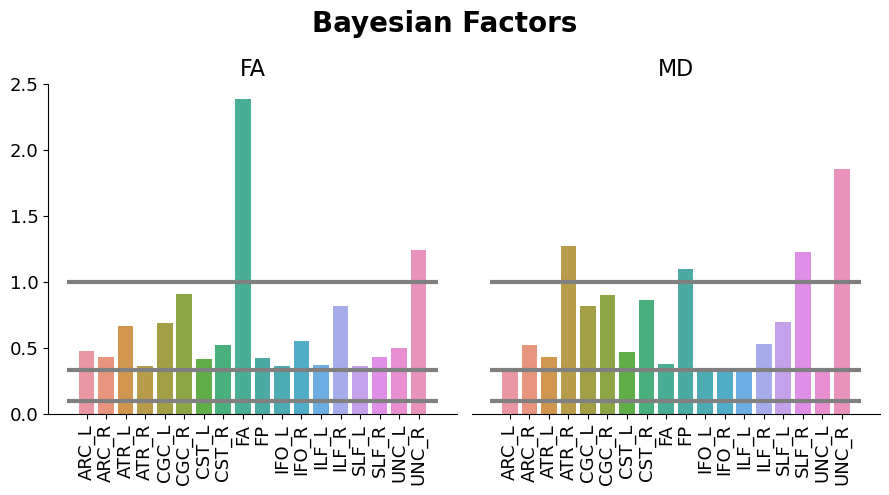

In [189]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(9,5))
fig.suptitle('Bayes Factors', fontweight="bold", size = 20)

sns.barplot(y= fa_stats_bf, x= tract_list, ax =ax1)
ax1.set_yticklabels(ax1.get_yticklabels(),size = 13)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 13, rotation = 90)
ax1.hlines(y = 1/10, xmin = -1, xmax = 18, color = 'gray', linewidth=3) # moderate evidence for null H
ax1.hlines(y = 1/3, xmin = -1, xmax = 18, color = 'gray', linewidth=3) # anecdotal evidence for null H
ax1.hlines(y = 1, xmin = -1, xmax = 18, color = 'gray', linewidth=3) # anecdotal evidence for alternative H
#ax1.hlines(y = 3, xmin = -1, xmax = 18, color = 'blue', linewidth=5)
ax1.set(ylim= (0,2.5))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['left'].set_visible(False)
ax1.set_title('FA', size =16)

sns.barplot(y= md_stats_bf, x= tract_list, ax = ax2)
ax2.set_yticklabels(ax2.get_yticklabels(),size = 13)
ax2.set_xticklabels(ax2.get_xticklabels(), size = 13, rotation = 90)
ax2.hlines(y = 1/10, xmin = -1, xmax = 18, color = 'gray', linewidth=3) # moderate evidence for null H
ax2.hlines(y = 1/3, xmin = -1, xmax = 18, color = 'gray', linewidth=3) # anecdotal evidence for null H
ax2.hlines(y = 1, xmin = -1, xmax = 18, color = 'gray', linewidth=3) # anecdotal evidence for alternative H
#ax2.hlines(y = 3, xmin = -1, xmax = 18, color = 'blue', linewidth=5)
ax2.set(ylim= (0,2.5))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_ticks([])
ax2.set_title('MD', size = 16)

fig.tight_layout()

In [190]:
fig.savefig('Bayes_Factors_clean_n35.tiff', format='tiff', dpi=1200)